In [2]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import load_dataset, get_pushed_loader_stats, get_Z_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.tools import weights_init_D
from src.plotters import plot_random_Z_images, plot_Z_images

from copy import deepcopy
import json

In [3]:
def tensor2img(tensor):
    return tensor.to('cpu').permute(0, 2, 3, 1).mul(0.5).add(0.5).numpy().clip(0, 1)

In [4]:
DATASET1, DATASET1_PATH = 'celeba_male', '../../data/img_align_celeba'
DATASET2, DATASET2_PATH = 'celeba_female', '../../data/img_align_celeba'

IMG_SIZE = 64

device = "cuda:3"

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=32, device=device)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=32, device=device)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(12)
Y_fixed = Y_sampler.sample(12)

X_test_fixed = X_test_sampler.sample(12)
Y_test_fixed = Y_test_sampler.sample(12)

In [7]:
filename

'../stats/celeba_female_64_test.json'

In [8]:
filename = '{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

In [9]:
path_to_model = "../checkpoints/mse/celeba_male_celeba_female_64/T.pt"

checkpoint = torch.load(path_to_model)

In [10]:
T = UNet(3, 3, base_factor=48)
T.load_state_dict(checkpoint)

T = T.to(device)
T.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(96, eps=1e-05, momentum=0.

In [11]:
print('Computing FID')
# use_downloaded_weights=True if weights are going to be loaded from internet, otherwise place in inception.py a path to weights
mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader, device=device, 
                                    use_downloaded_weights=True)
fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)

Computing FID


/cache/selikhanovych/ot/NeuralOptimalTransport/notebooks/../src/unet.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
/cache/selikhanovych/ot/NeuralOptimalTransport/notebooks/../src/unet.py:62: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  diffY // 2, diffY - diffY // 2])


In [12]:
fid

13.315355904189914

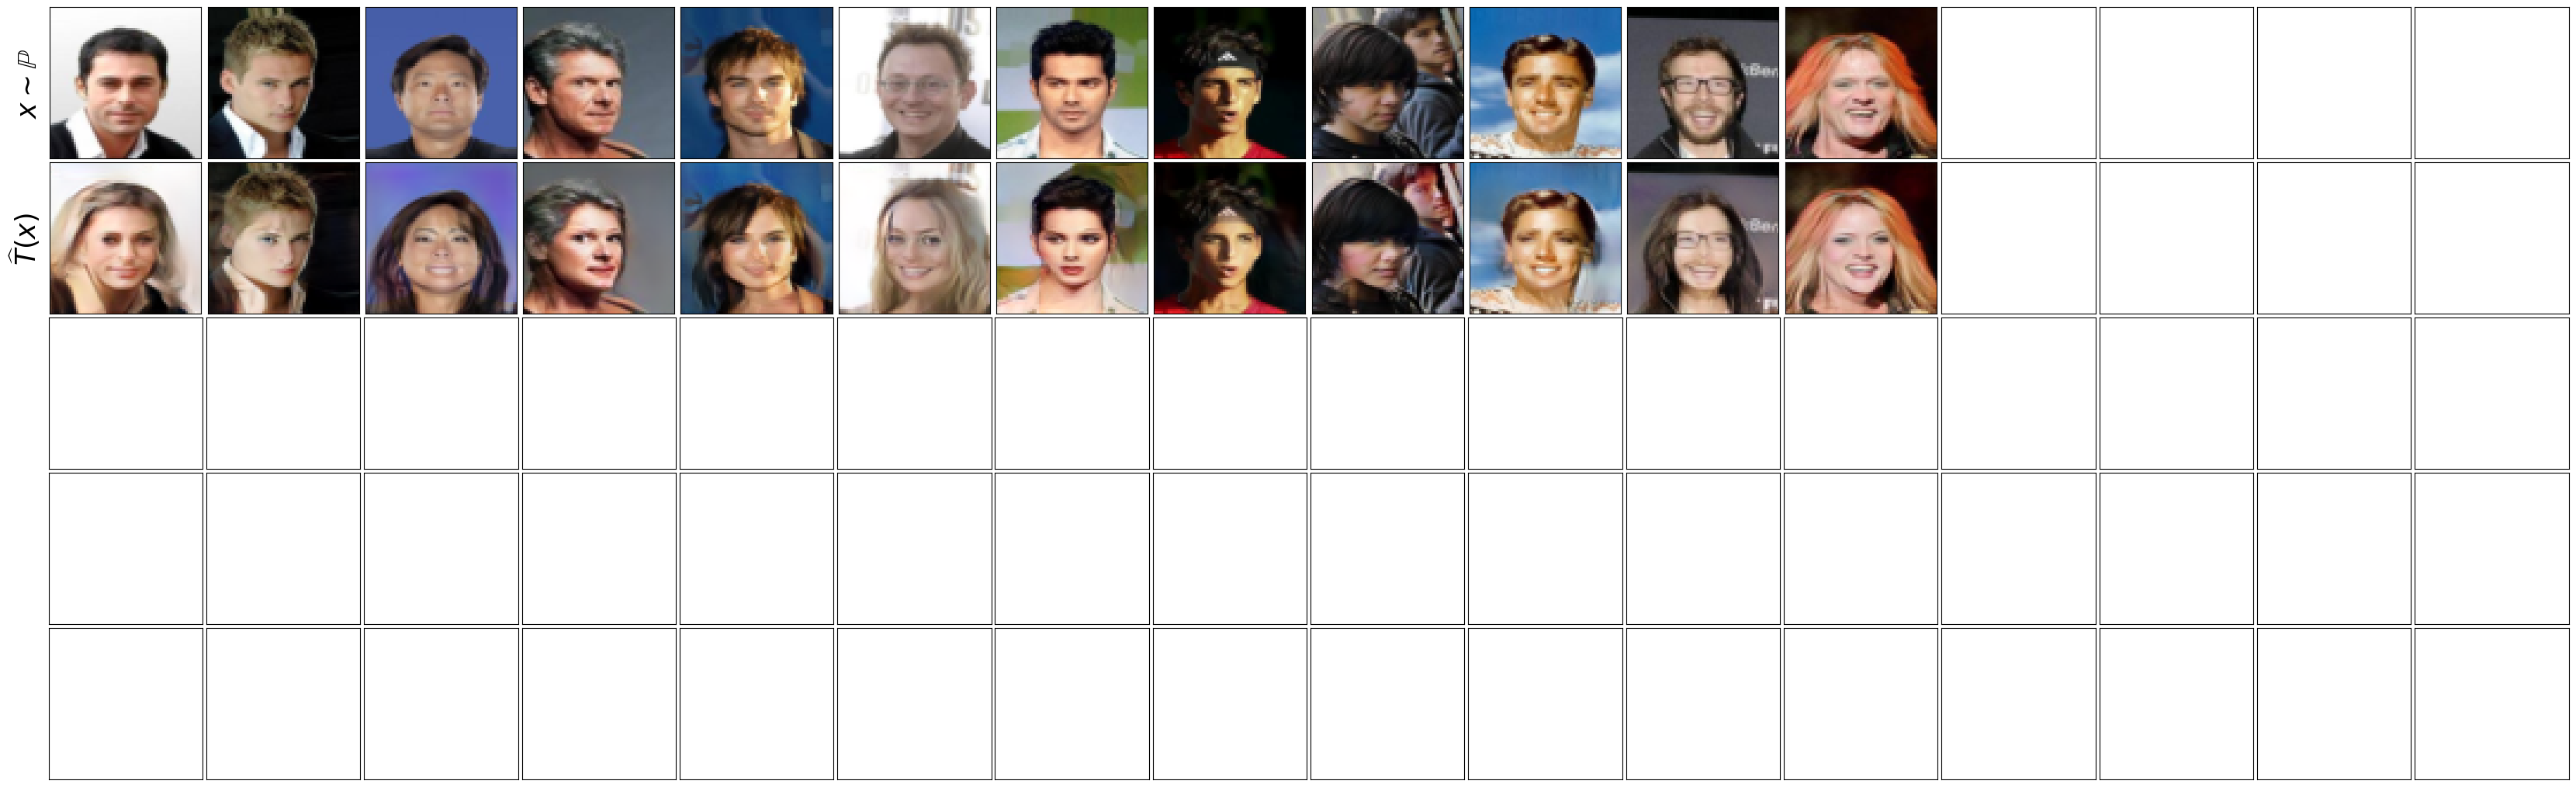

In [13]:
AB_test = T(X_test_fixed).detach()

fake_Y_test_numpy = tensor2img(AB_test)
real_X_test_numpy = tensor2img(X_test_fixed)

fig, axes = plt.subplots(5, 16, figsize=(16*2+1,10), dpi=100)
X_tensor = real_X_test_numpy

for j in range(12):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    
    axes[1][j].imshow(fake_Y_test_numpy[j])
    axes[1][j].get_xaxis().set_visible(False)
    axes[1][j].set_yticks([])
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=25)
title = '\widehat{T}(x)'
axes[1, 0].set_ylabel(r'${}$'.format(title), fontsize=25) 

for i, ax in enumerate(axes.flatten()):
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])
    
fig.tight_layout(pad=0.001)    
plt.savefig("not_strong_male2female_test.png")

In [14]:
def load_checkpoint(checkpoint):
    new_dict = {}
    start_len = len("module.")
    for key in checkpoint.keys():
        new_dict[key[start_len:]] = checkpoint[key]
        
    return new_dict

In [17]:
path_to_model = "../checkpoints/weak_mse/celeba_male_celeba_female_64/T.pt"

checkpoint = torch.load(path_to_model)
new_dict = checkpoint

In [18]:
ZC = 1
Z_STD = 0.1
T = UNet(3+ZC, 3, base_factor=48)
T.load_state_dict(new_dict)

T = T.to(device)
T.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(96, eps=1e-05, momentum=0.

In [19]:
torch.manual_seed(24)
np.random.seed(24)

num_examples = 4
Y_test_fakes = []

for v in range(num_examples):
    Z = torch.randn(X_test_fixed.size(0), ZC, X_test_fixed.size(2), X_test_fixed.size(3), device=device) * Z_STD
    X = X_sampler.sample(10)[:,None].repeat(1,4,1,1,1)
    XZ = torch.cat([X_test_fixed, Z], dim=1)
    
    fake_Y_test = T(XZ).detach()
    fake_Y_test_numpy = tensor2img(fake_Y_test)
    Y_test_fakes.append(fake_Y_test_numpy)

real_X_test_numpy = tensor2img(X_test_fixed)
real_Y_test_numpy = tensor2img(Y_test_fixed)

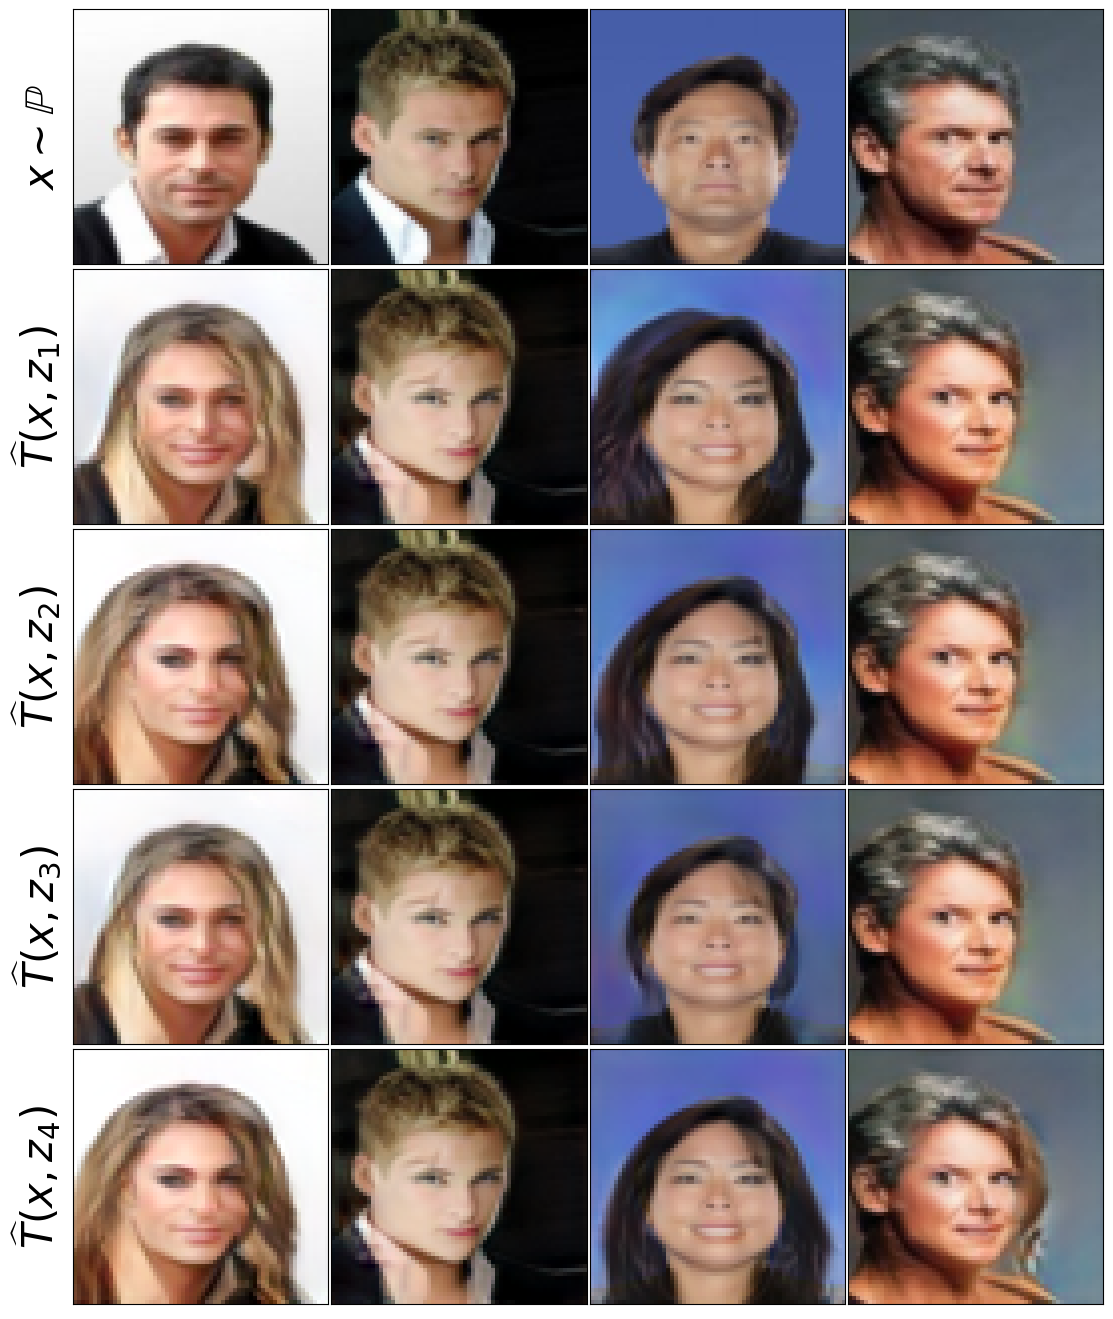

In [20]:
fig, axes = plt.subplots(5, 4, figsize=(11, 13), dpi=100)
X_tensor = real_X_test_numpy
Y_tensor = real_Y_test_numpy
Y_fake_tensor = Y_test_fakes

for j in range(4):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    #axes[0][j].get_yaxis().set_visible(False)

for i in range(4):
    for j in range(4):
        cur_img = Y_fake_tensor[i][j]

        axes[i + 1][j].imshow(cur_img)
        axes[i + 1][j].get_xaxis().set_visible(False)
        axes[i + 1][j].set_yticks([])
        #axes[i + 1][j].get_yaxis().set_visible(False)
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=30)
for j in range(4):
    title = '\widehat{T}(x,z_' + str(j+1) + ')'
    axes[j+1, 0].set_ylabel(r'${}$'.format(title), fontsize=30)
    
fig.tight_layout(pad=0.001)    
plt.savefig("weak_ot_male2female_test.png")

In [ ]:
5